In [1]:
import sys
sys.path.append('E:\\Desktop\\omipolar\\DataPlotting')
import organoidContour as oc
from organoidContour import data
from organoidContour import preprocessing
sys.path.append('E:\\Desktop\\omipolar\\DataPlotting\\load_intan_rhs_format')
import load_intan_rhs_format as ld
import numpy as np
%matplotlib inline
sampling_rate = 10000
use_raw_data = 0
cutoff_frequency = 1000


data_path = "E:\Desktop\omipolar\DataPlotting\paramsFor10sOthers\data\FY 5kCO2 serotonin_240529_110019\FY 5kCO2 serotonin_240529_112019.rhs"

#data_path = "E:\Desktop\omipolar\DataPlotting\JKCO\E-4031 test_2024-05-20\JK CO4 folded 1_240520_135929\JK CO4 folded 1_240520_141029.rhs"
data_path = r"E:\Desktop\omipolar\DataPlotting\JKCO\E-4031 test_2024-05-20\JK CO4 folded 1_240520_142157\JK CO4 folded 1_240520_143958.rhs"

wanted_channel = list(range(16))

#processed_data = preprocessing.processingPipline(data_paths['data_1'], data_paths['data_2'])
processed_data = preprocessing.processingPipline(data_path, data_path, cutoff=cutoff_frequency,fs_new= sampling_rate, one_address= 1)
#raw_data = preprocessing.extract_raw_data(data_path, data_path)
available_data = processed_data#[wanted_channel]

if use_raw_data:
    raw_data = preprocessing.extract_raw_data(data_path, data_path)
    available_data = raw_data;sampling_rate = 30000

available_data[:7] = available_data[2:9]



Reading Intan Technologies RHS Data File, Version 3.3

Found 16 amplifier channels.
Found 0 board ADC channels.
Found 0 board DAC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.

File contains 60.002 seconds of data.  Amplifiers were sampled at 30.00 kS/s.
numsamples and numblocks
1800064
14063
FINISHED HEADER

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 2.3 seconds
Filtering Data...
Filtering Done!


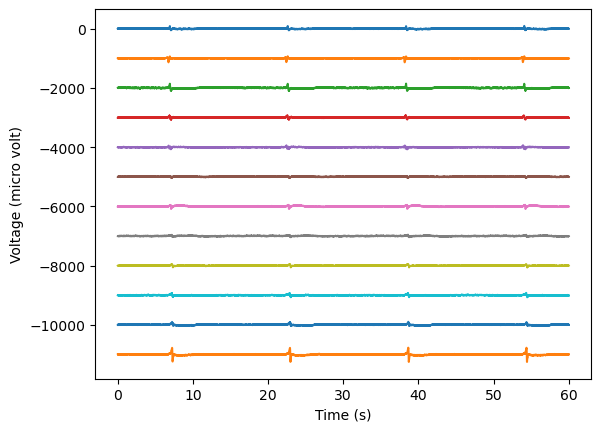

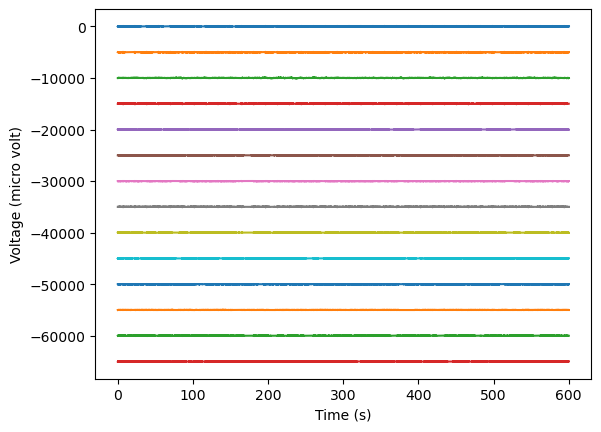

In [20]:
target_indeces = [3,5,11]

intan_chennels = [3,5,27]
fifteen = False
target_indeces = [0,1,3,4, 5,6, 9,10, 12,13, 14, 15]
if fifteen:
    target_indeces = [0,1,2,3, 5,6,7,8,9,10,11, 12,13, 14, 15]

intan_chennels = [0,1,2,3,4,5,6,7,24,25,26,27,28,29]

target_data = available_data[target_indeces]
target_data_copy = target_data.copy()
preprocessing.plotWaves(available_data, 
            target_indeces, start= 00000, sample= 60000, interval = 1000)
wanted_channel = list(range(14))

preprocessing.plotWaves(processed_data, wanted_channel, start= 0000, sample= 600000, interval= 5000)

In [21]:
from organoidContour import spike
from organoidContour.spike import *
from organoidContour import spike
import importlib
importlib.reload(spike)
from organoidContour.spike import *

In [22]:
def find_peak_based_on_reference_channel(data, reference_index, max = [1,1,-1,1,1,1,1,1,-1,-1,1,1], peak_range = (200,200), sd=2, multi = 1, reference_peak = None):
    # In shape of #channels * # peaks
    peaks = detect_peak(data[reference_index], sd=sd, multi = multi)
    print(peaks)
    if reference_peak is not None:
        peaks = reference_peak
    #peaks = auto_threshold_detect_spike_peaks(data[reference_index], plot=1)
    all_peak = np.zeros((data.shape[0],len(peaks)))
    j = 0 # Channel index
    k = -1 # Peak index
    for peak in peaks:
        j = 0
        k = k+1
        for i in range(data.shape[0]):
            all_peak[j,k] = find_peak(data[i], peak - peak_range[0], peak+peak_range[1],max[j] )
            j = j+1
    return all_peak

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

def rank_confusion_matrix(peaks):
    # Assuming peaks is defined elsewhere in your code with shape (number of channels, number of spikes)
    num_spikes = peaks.shape[1]
    num_channels = peaks.shape[0]

    # Initialize the matrix to hold the firing order of channels for each spike
    firing_order_matrix = np.zeros((num_spikes, num_channels), dtype=int)

    # For each spike, find the channel that fires first, then second, and so on
    for spike in range(num_spikes):
        firing_order = np.argsort(peaks[:, spike])
        firing_order_matrix[spike, :] = firing_order

    confusion_matrix_like = np.zeros((num_channels, num_channels))

    # Build the matrix where rows are firing orders and columns are channels
    for i in range(num_spikes):
        for j in range(num_channels):
            channel = firing_order_matrix[i, j]
            confusion_matrix_like[j, channel] += 1

    # Plotting the "confusion matrix"
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_like, annot=True, cmap="YlGnBu", fmt="g",
                xticklabels=[f"Channel {i+1}" for i in range(num_channels)],
                yticklabels=[f"Order {i+1}" for i in range(num_channels)])
    plt.title('Channel Firing Order Across Spikes')
    plt.xlabel('Channels')
    plt.ylabel('Firing Order')
    plt.show()

    # Convert the problem to a maximization problem for Hungarian algorithm
    cost_matrix = confusion_matrix_like.max() - confusion_matrix_like

    # Apply the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Create a new sorted confusion matrix based on column assignment
    sorted_confusion_matrix = confusion_matrix_like[:, col_ind]

    # Accuracy based on sorted columns and their original firing orders
    accuracy = np.trace(sorted_confusion_matrix) / np.sum(sorted_confusion_matrix)

    # Plotting the sorted "confusion matrix"
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_confusion_matrix, annot=True, cmap="YlGnBu", fmt="g",
                xticklabels=[f"Channel {col+1}" for col in col_ind], 
                yticklabels=[f"Order {i+1}" for i in range(num_channels)])
    plt.title(f'Sorted Channel Firing Order Across Spikes: Accuracy = {accuracy:.4f}')
    plt.xlabel('Channels')
    plt.ylabel('Firing Order')
    plt.show()

    return sorted_confusion_matrix, col_ind  # Returning both the matrix and the sorted indices


import numpy as np
import matplotlib.pyplot as plt


def spike_overlay_multiple_channel(data, peaks, window_size=1000, title=None, save=False):
    """
    Overlay plots of spike peaks for multiple channels, aligning each peak in the same plot.
    
    Parameters:
    - data: 2D numpy array, where each row represents a channel (shape: [num_channels, num_samples]).
    - peaks: list of lists, each containing the peak indices for the corresponding channel.
    - window_size: int, the number of data points to include before and after each peak.
    - title: str, optional, title for the combined plot.
    - save: bool, optional, if True, saves the figure to a file.
    
    Returns:
    - None, but generates and optionally saves a combined plot for all channels.
    """
    num_channels = data.shape[0]

    plt.figure(figsize=(12, 8))

    # Number of points to plot before and after the peak
    window_1 = int(window_size * 0.3)
    window_2 = window_size - window_1

    # Loop through each channel and collect data for overlay
    for channel_idx in range(num_channels):
        channel_data = data[channel_idx]
        channel_peaks = peaks[channel_idx]
        all_segments = []

        # Extract aligned segments around each peak
        for peak_index in channel_peaks:
            start = int(max(0, peak_index - window_1))
            end = int(min(len(channel_data), peak_index + window_2 + 1))
            segment = channel_data[start:end]

            if len(segment) == window_size + 1:
                all_segments.append(segment)
                #plt.plot(segment, color='gray', alpha=0.3)

        # Compute mean segment for the channel and plot
        if len(all_segments) > 0:
            mean_segment = np.mean(np.array(all_segments), axis=0)
            plt.plot(mean_segment)

    # Add vertical line for alignment and labels
    plt.axvline(x=window_1, color='red', linestyle='--', label='Aligned Peaks')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (uV)')
    if title:
        plt.title(title)
    else:
        plt.title('Overlay of Spike Peaks for All Channels')

    plt.legend()

    # Save the plot if required
    if save:
        filename = f"./SpikeOverlay/CombinedOverlay.png"
        plt.savefig(filename, dpi=600)

    plt.show()

# Example usage:
# data = np.random.rand(16, 10000)  # Example data with 16 channels and 10000 samples per channel
# peaks = [list(np.random.randint(100, 9900, size=20)) for _ in range(16)]  # Random peaks for each channel
# spike_overlay_multiple_channel(data, peaks, window_size=1000, title="Combined Spike Overlay", save=True)




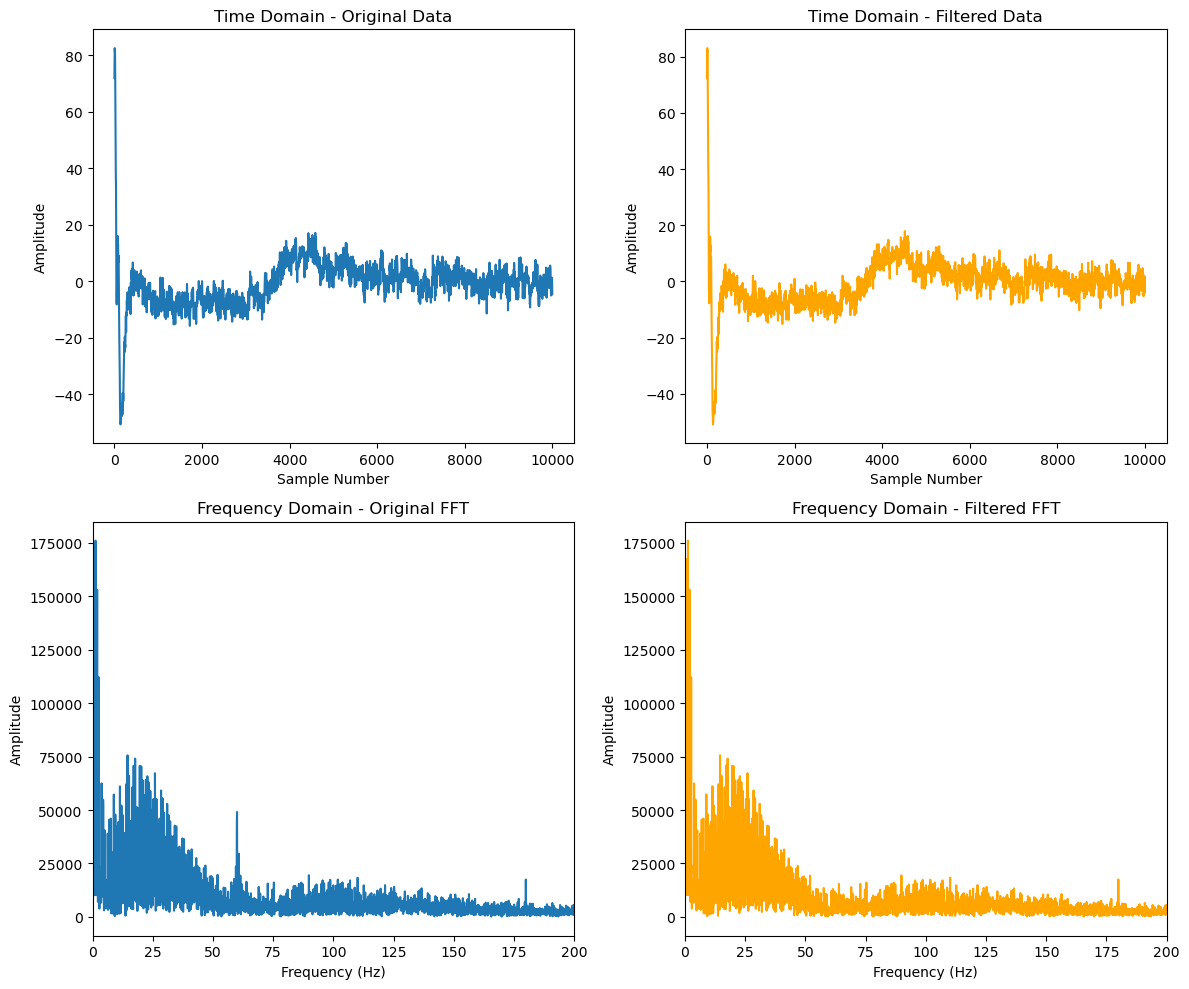

In [23]:
prepare_filter = True
fs = 10000  # Sampling rate in Hz
lowcut = 16  # Low cut frequency in Hz
highcut = 17  # High cut frequency in Hz
lowcut_2 = 59
highcut_2 = 61
lowcut_3 = 59
highcut_3 = 61
%matplotlib inline
if (prepare_filter):
    channel = target_data_copy[:,7*fs:20*fs][0]

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import butter, filtfilt


    # Sampling rate and filter parameters



    # Create the bandstop filter
    b, a = butter(N=1, Wn=[lowcut, highcut], btype='bandstop', fs=fs)

    b_2, a_2 = butter(N=1, Wn=[lowcut_2, highcut_2], btype='bandstop', fs=fs)

    b_3, a_3 = butter(N=1, Wn=[lowcut_3, highcut_3], btype='bandstop', fs=fs)
    # Apply the filter
    filtered_data = filtfilt(b_2,a_2, channel)

    # Compute the FFT of the original and filtered data
    frequencies = np.fft.rfftfreq(channel.size, d=1./fs)
    original_fft = np.abs(np.fft.rfft(channel))
    filtered_fft = np.abs(np.fft.rfft(filtered_data))

    # Plotting
    plt.figure(figsize=(12, 10))

    # Time domain - original data
    plt.subplot(2, 2, 1)
    plt.plot(channel[:fs], label='Original Data')
    plt.title('Time Domain - Original Data')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')

    # Time domain - filtered data
    plt.subplot(2, 2, 2)
    plt.plot(filtered_data[:fs], label='Filtered Data', color='orange')
    plt.title('Time Domain - Filtered Data')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')

    # Frequency domain - original FFT
    plt.subplot(2, 2, 3)
    plt.plot(frequencies, original_fft, label='Original FFT')
    plt.xlim([0,200])
    plt.title('Frequency Domain - Original FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    #plt.xlim(0, fs/2)

    # Frequency domain - filtered FFT
    plt.subplot(2, 2, 4)
    plt.plot(frequencies, filtered_fft, label='Filtered FFT', color='orange')
    plt.xlim([0,200])
    plt.title('Frequency Domain - Filtered FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    #plt.xlim(0, fs/2)

    plt.tight_layout()
    plt.show()


In [24]:
def find_slop(x, a, b, max=1):
    # find the index of the max or min value in a 1d array at a:b
    # Return the index
    # Check if the range is valid
    if a < 0 or b >= len(x) or a > b:
        #print("Error when trying to find the slop",a,b)
        return -1  # Return -1 or some error indication for invalid range
    a = int(a)
    b = int(b)
    # Initialize the index and value of the peak
    peak_index = a
    peak_value = x[a] - x[a+1]
    # Iterate over the range a to b
    for i in range(a + 1, b + 1):
        # Check if we are finding max or min
        if (x[i] - x[i+1] > peak_value):
            peak_value = x[i] - x[i+1]
            peak_index = i

    return peak_index
def find_activation_slope(data, reference_index, peak_range = (200,200), sd=2, multi = 1, reference_peak = None):
    # In shape of #channels * # peaks
    peaks = detect_peak(data[reference_index], sd=sd, multi = multi)
    
    if reference_peak is not None:
        peaks = reference_peak
    #peaks = auto_threshold_detect_spike_peaks(data[reference_index], plot=1)
    all_peak = np.zeros((data.shape[0],len(peaks)))
    j = 0 # Channel index
    k = -1 # Peak index
    for peak in peaks:
        j = 0
        k = k+1
        for i in range(data.shape[0]):
            all_peak[j,k] = find_slop(data[i], peak - peak_range[0], peak+peak_range[1] )
            j = j+1
    return all_peak


In [25]:
from organoidContour import spike
import importlib
# importlib.reload(spike)
from organoidContour.spike import *
direction = np.zeros((target_data.shape[0],1))+1
#direction[1] = 1
%matplotlib inline

bpm_over_time, peaks_neo = process_electrodes(target_data[:,0*sampling_rate:60*sampling_rate], sampling_rate, threshold_val=[1,13])
print(len(peaks_neo[1]))
peaks = find_peak_based_on_reference_channel(target_data[:,0*sampling_rate:60*sampling_rate],1,direction, 
                                        peak_range= (int(200*sampling_rate/1000),int(200*sampling_rate/1000)), sd = 2, multi= 1,reference_peak=peaks_neo[1])
print(peaks.shape)

peaks = peaks[:, 1:]
peaks_max = peaks.copy()
largest_slop = peaks

peak_ranges = [(250, 250), (250, 0),
                (0, 100), (250, 250),
                (250, 100), (250, 250),
                (0, 250), (250, 250),
                (250, 250), (250, 250),
                (250, 250), (250, 250),
                (250, 250), (250, 250)]

if fifteen:
    peak_ranges = [(0,100),(300,250),
                (0,250),(500,000),
                (0,250),(0,150),
                (0,250),(0,450),
                (0,250),(10,100),
                (0,250),
                (0,250),
                (0,100),(300,00),
                (0,100),
                (300,0)]

filtered_data = target_data[:,0*sampling_rate:60*sampling_rate]
for i in range(target_data.shape[0]):    

    filtered_data[i] = filtfilt(b_2, a_2, target_data[i,0*sampling_rate:60*sampling_rate])
    #filtered_data[i] = target_data_copy[i,0*sampling_rate:60*sampling_rate]
    single_slope = find_activation_slope(filtered_data,3,
                                peak_range= peak_ranges[i], sd = 2, multi= 1,reference_peak=peaks_max[i])[i]
    largest_slop[i] = single_slope
    peaks[i] = largest_slop[i]


largest_slop = largest_slop[:,:-1]
peaks = largest_slop
latency = np.mean(largest_slop - np.min(largest_slop, axis=0), axis= 1)

#peaks_save = peaks_save[:,:-1]
#latency = np.mean(peaks_save - np.min(peaks_save, axis=0), axis= 1)

38
(12, 38)


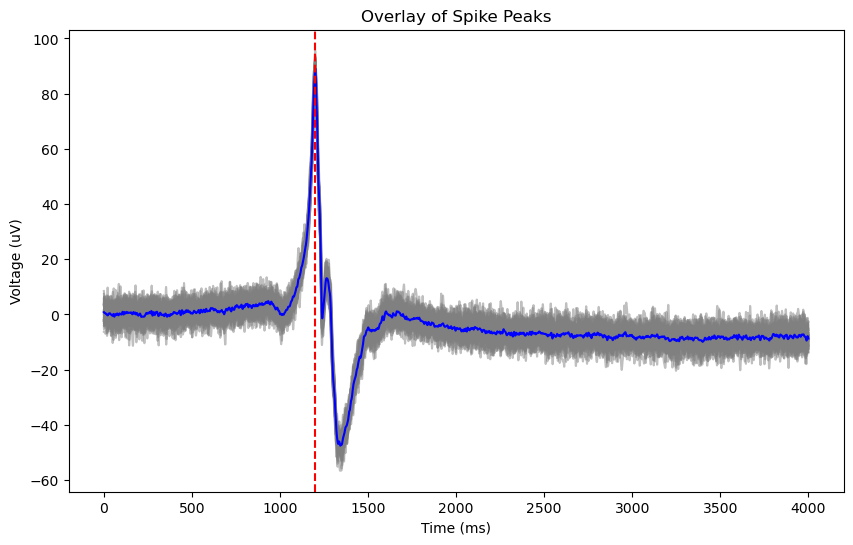

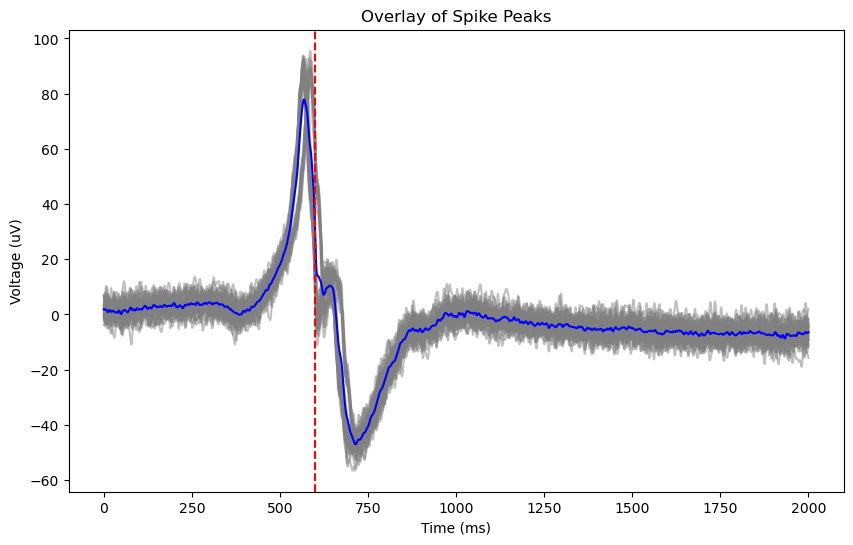

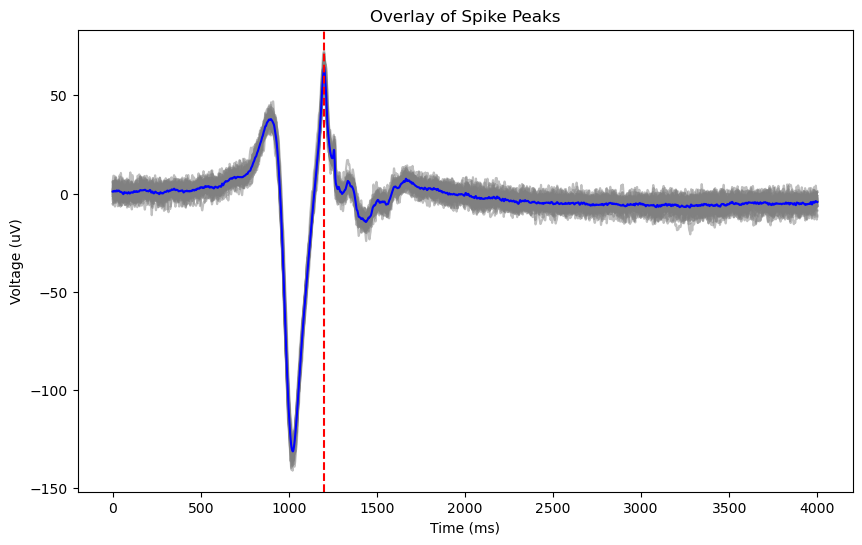

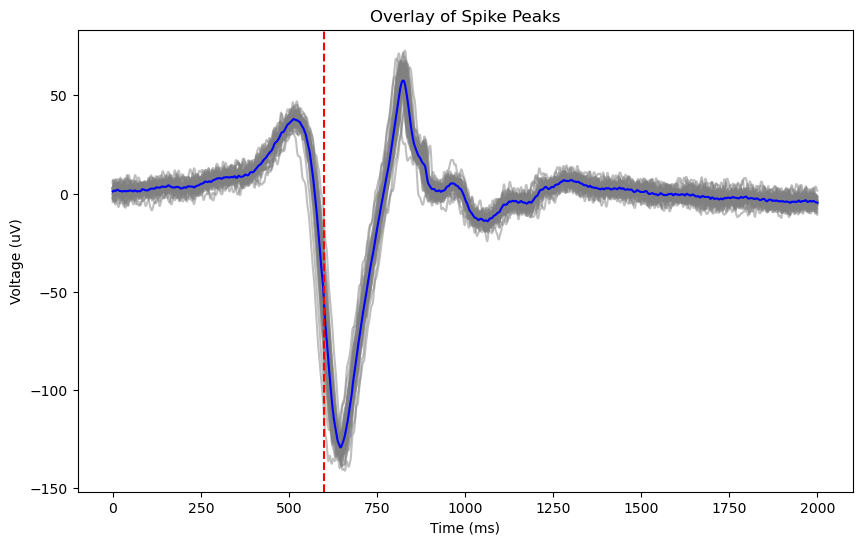

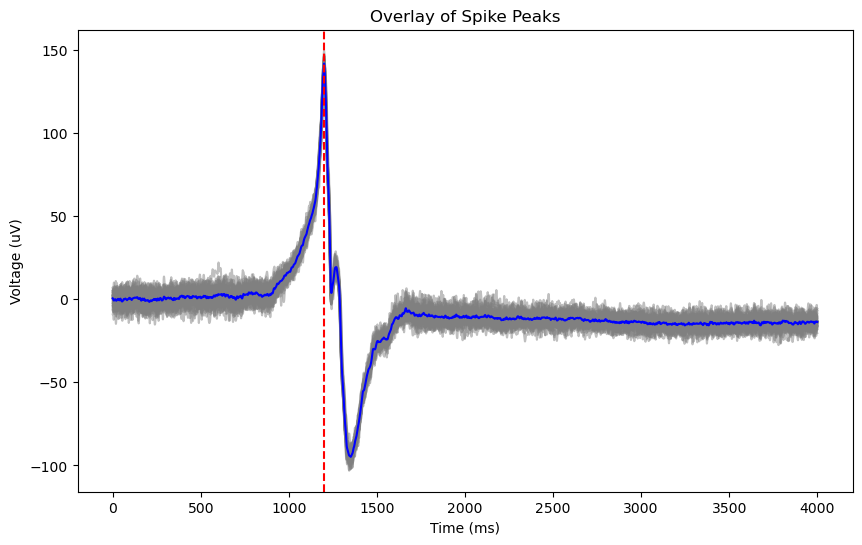

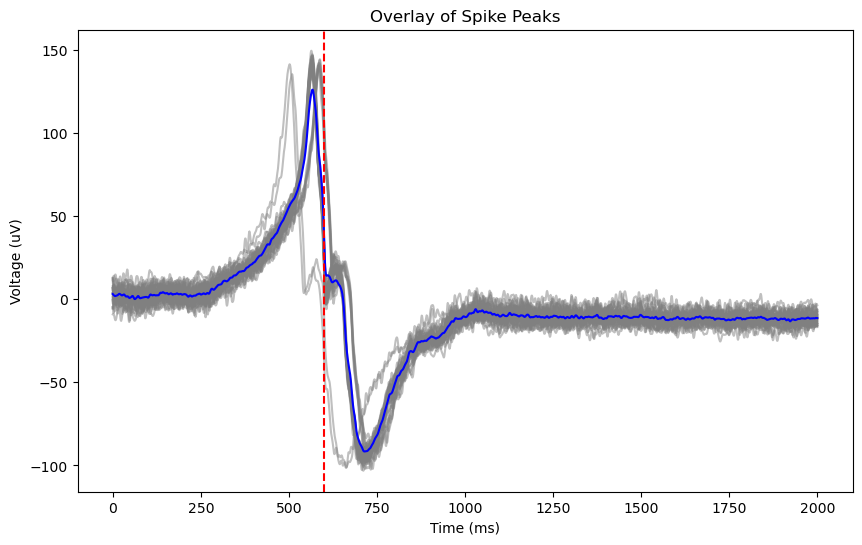

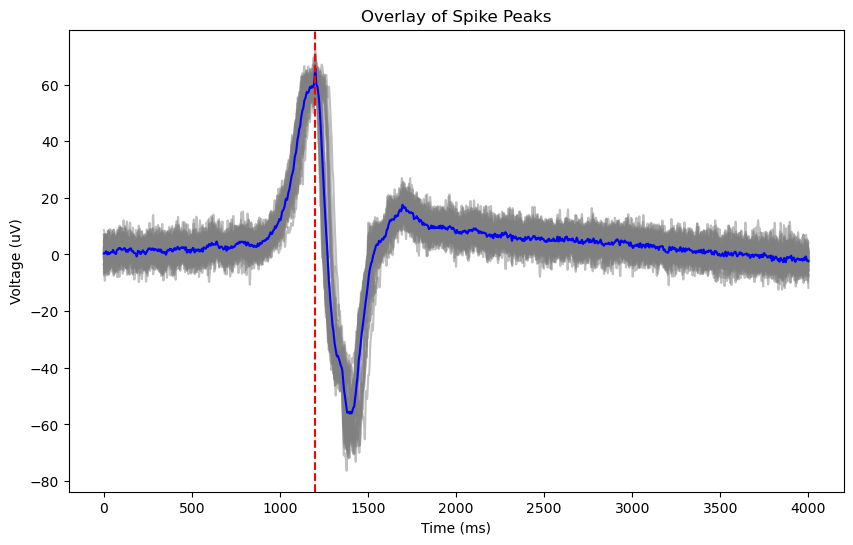

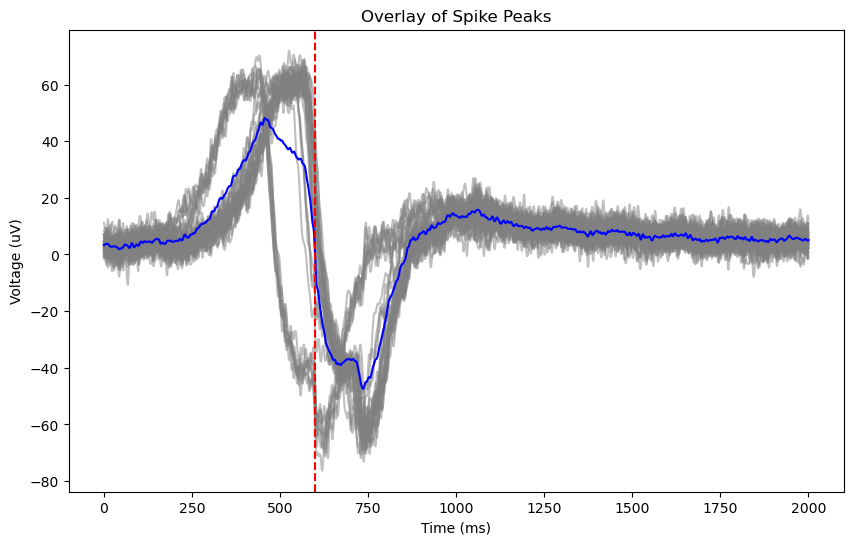

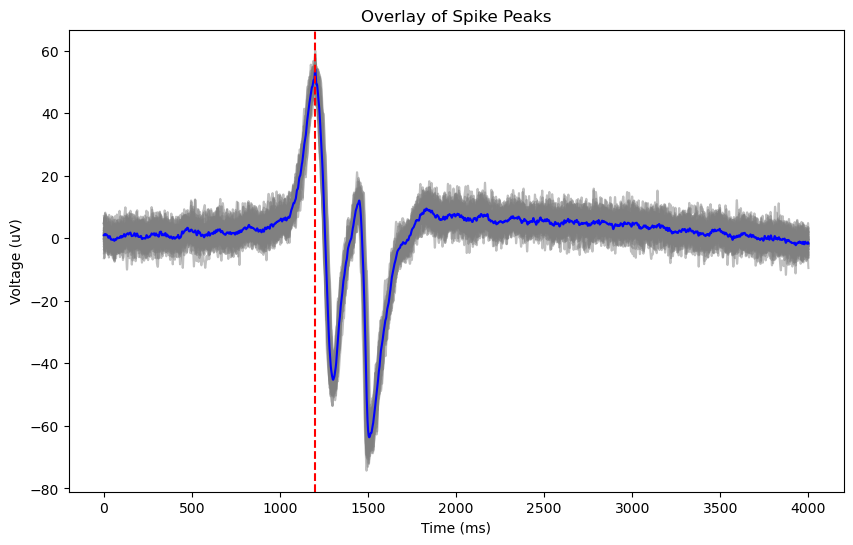

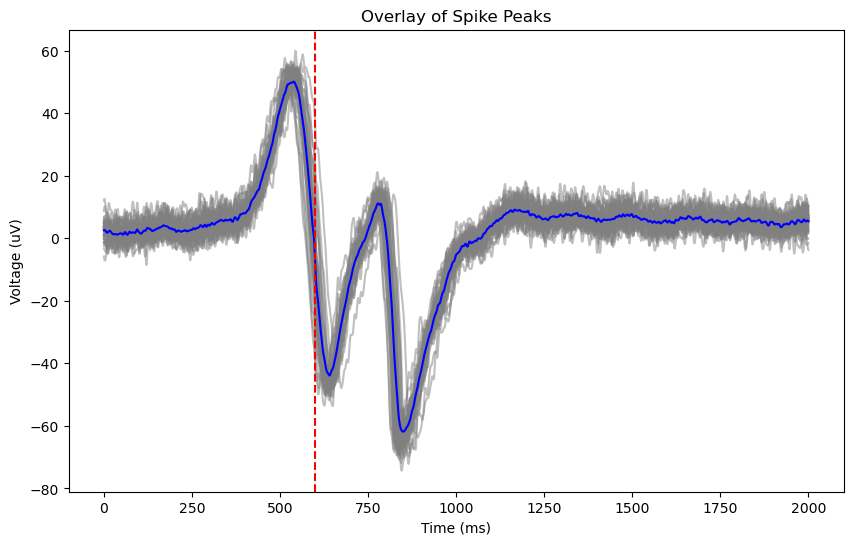

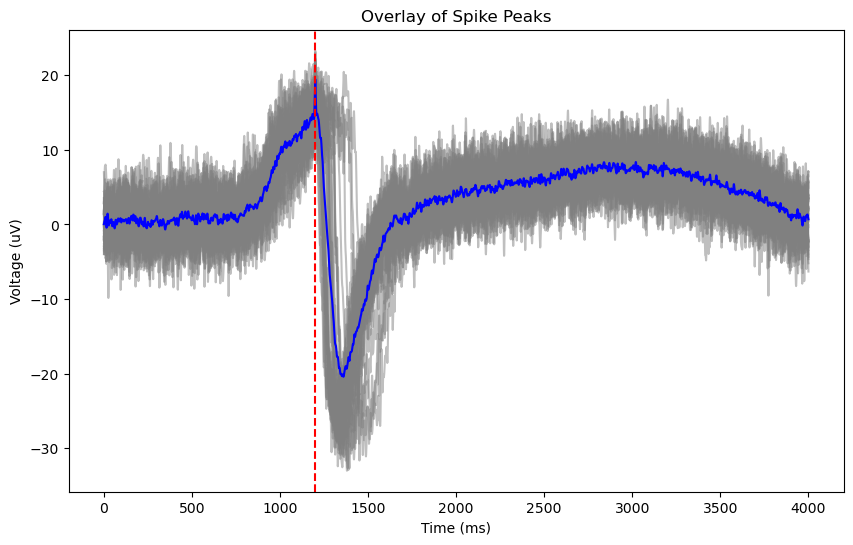

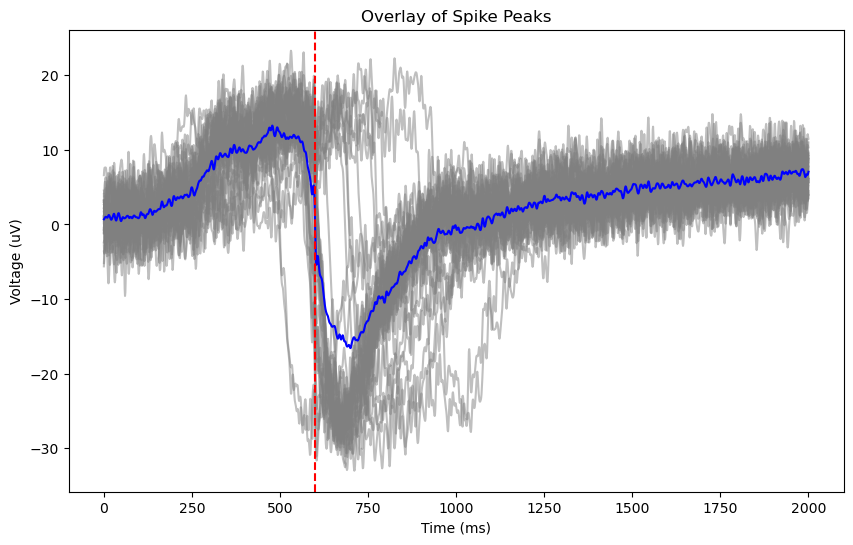

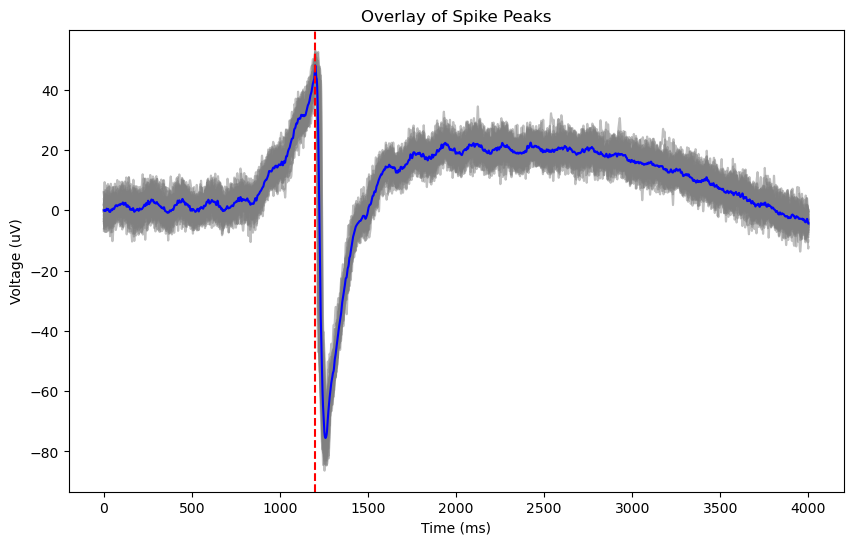

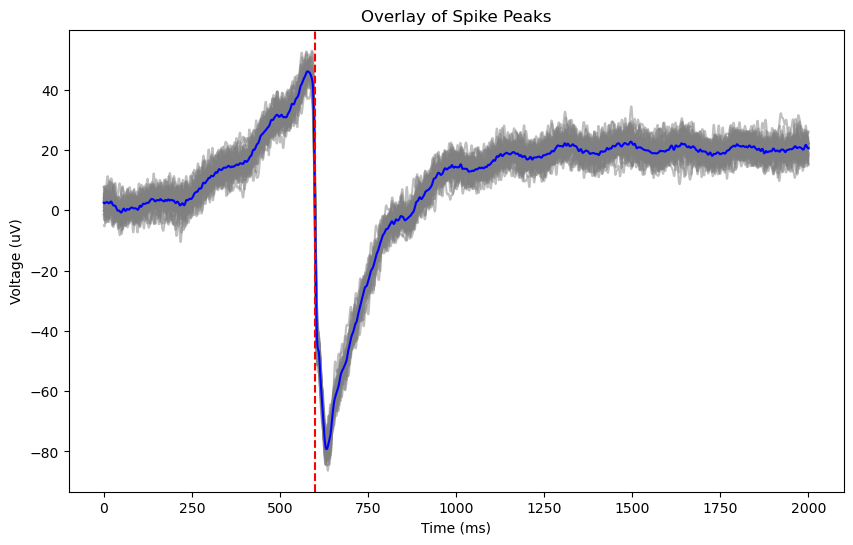

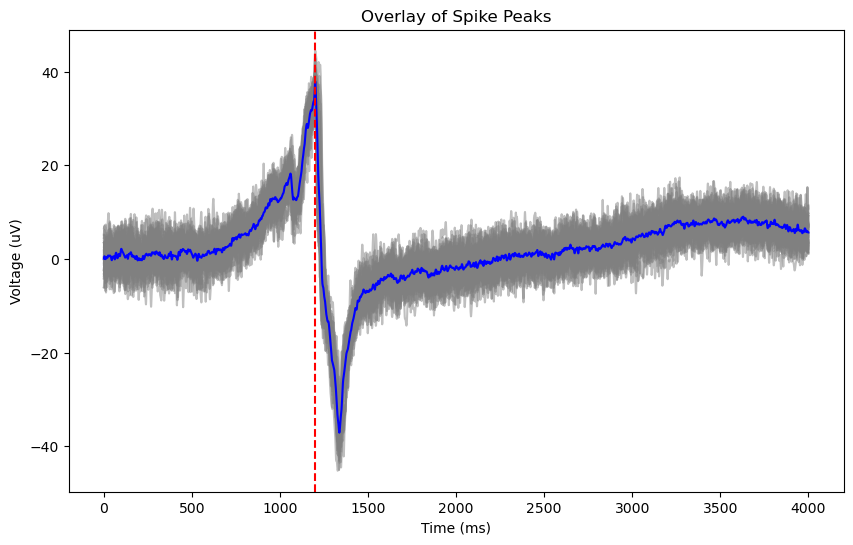

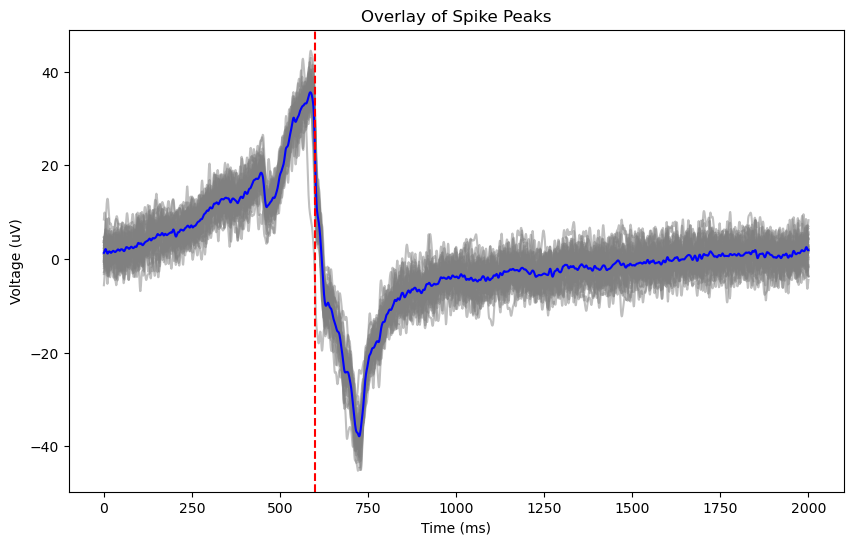

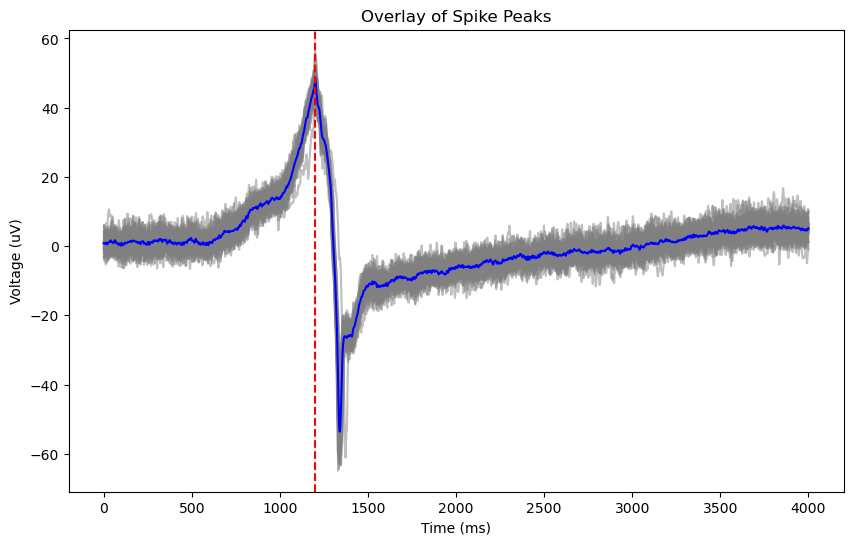

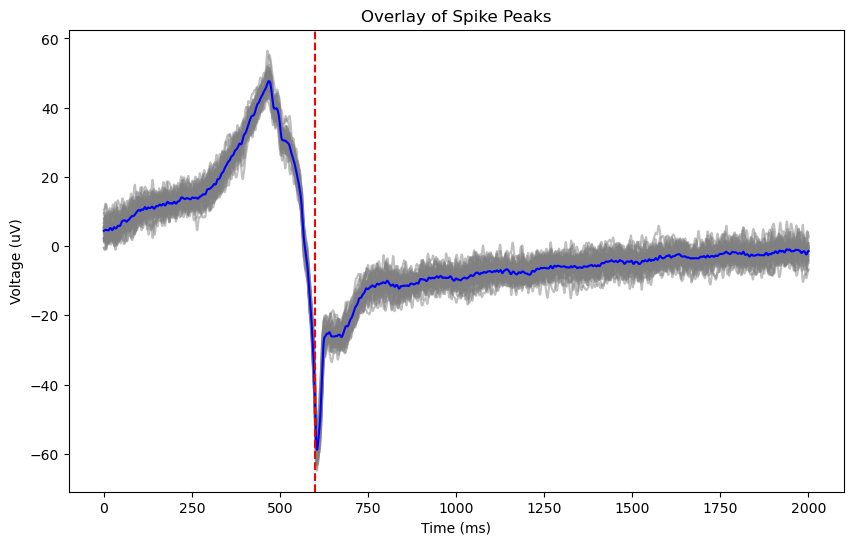

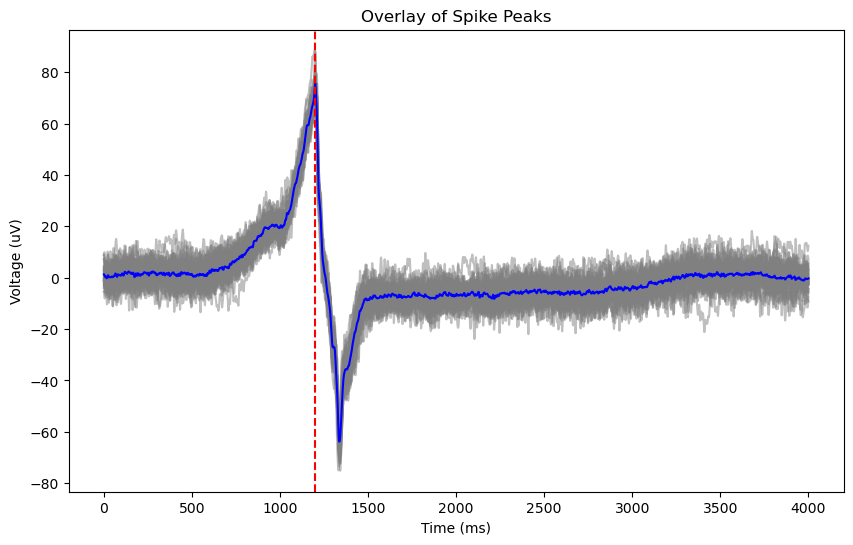

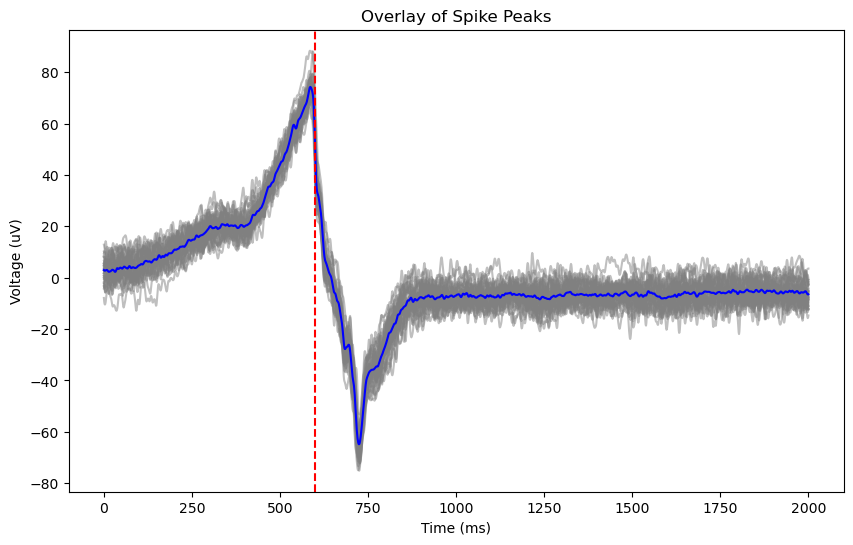

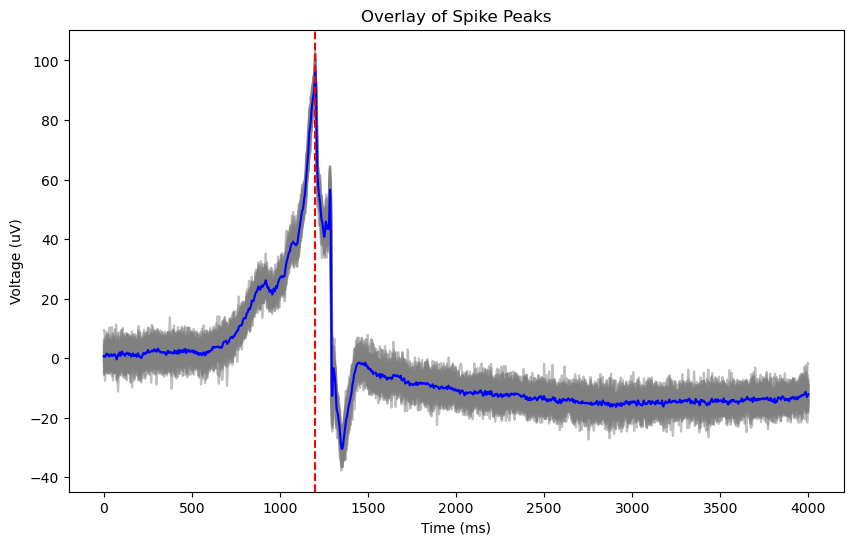

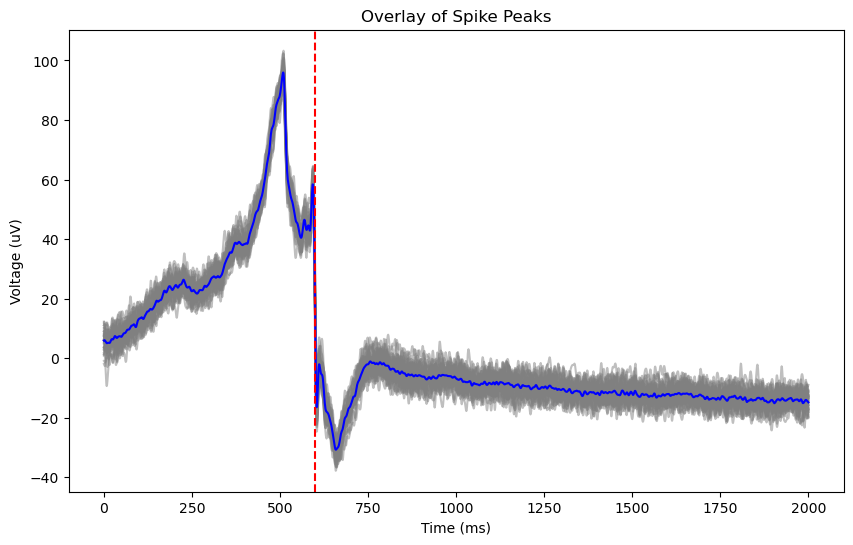

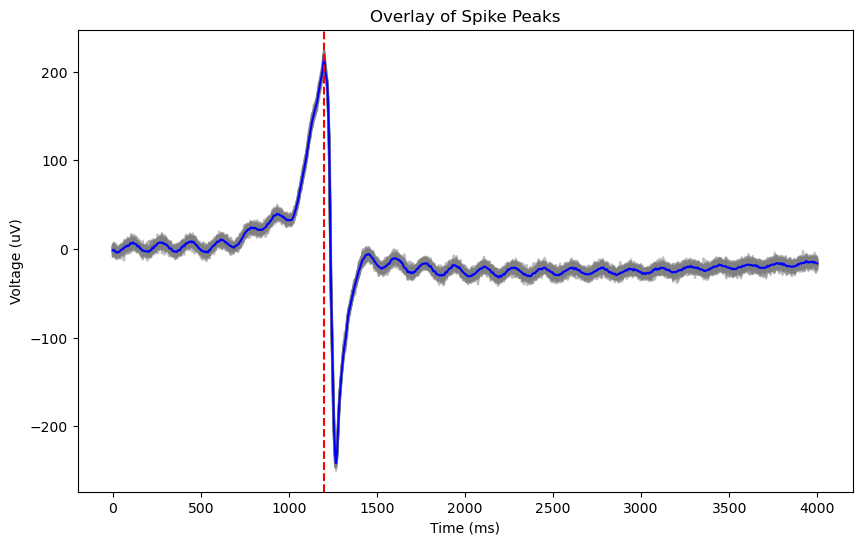

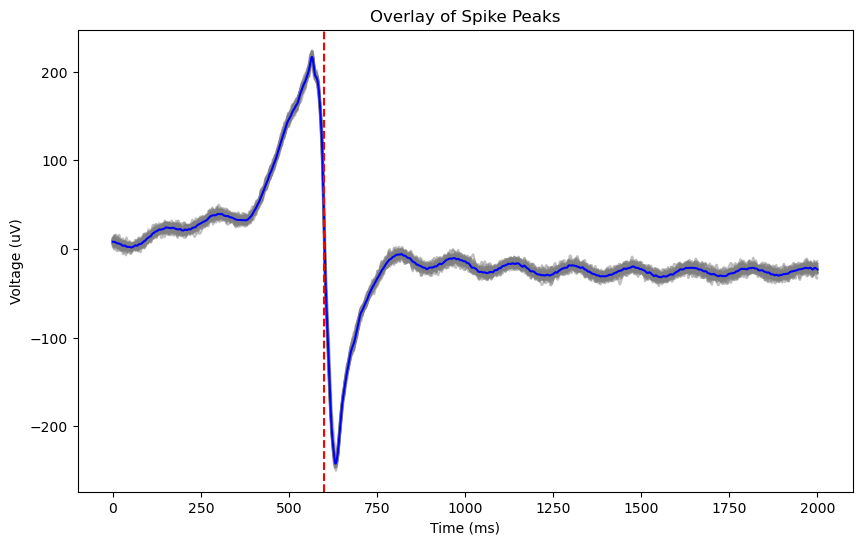

IndexError: index 12 is out of bounds for axis 0 with size 12

In [26]:
for i in range(10):
    overlay_spike_peaks(filtered_data[i], peaks_max[i], window_size=4000, title = None, save = False)
    overlay_spike_peaks(filtered_data[i], peaks[i], window_size=2000, title = None, save = False)
   

In [27]:
largest_slop_noisy = largest_slop.copy()
largest_slop = np.delete(largest_slop, [20,21,22], axis=1)
peaks_noisy = peaks.copy()
peaks = np.delete(peaks, [20,21,22], axis=1)
latency_all = (largest_slop - np.min(largest_slop, axis=0))
latency = np.mean(largest_slop - np.min(largest_slop, axis=0), axis= 1)
latency.max()


619.2424242424242

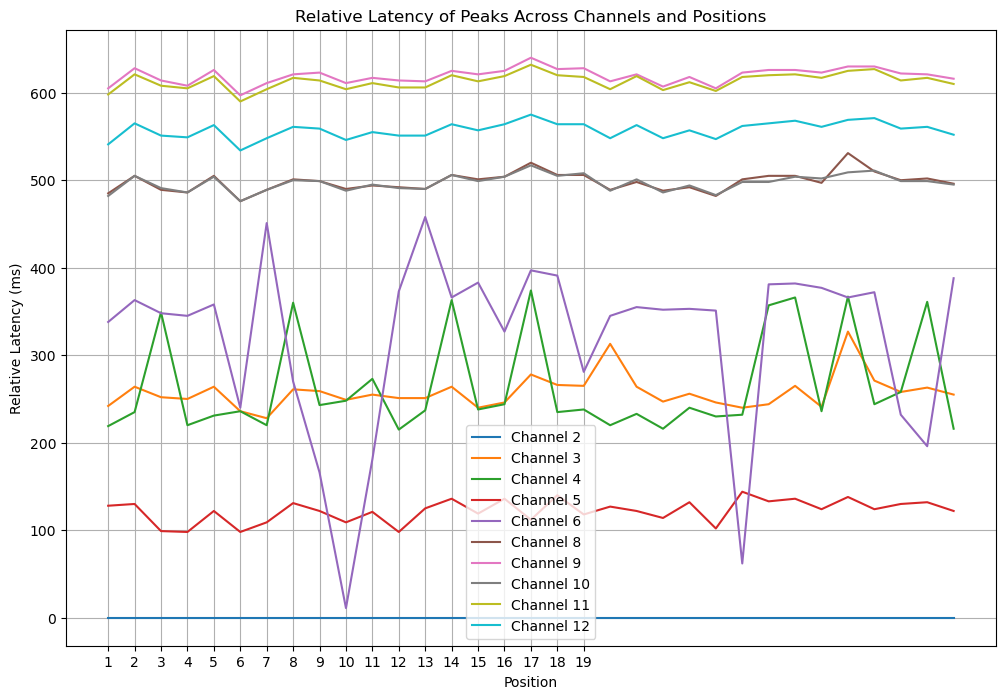

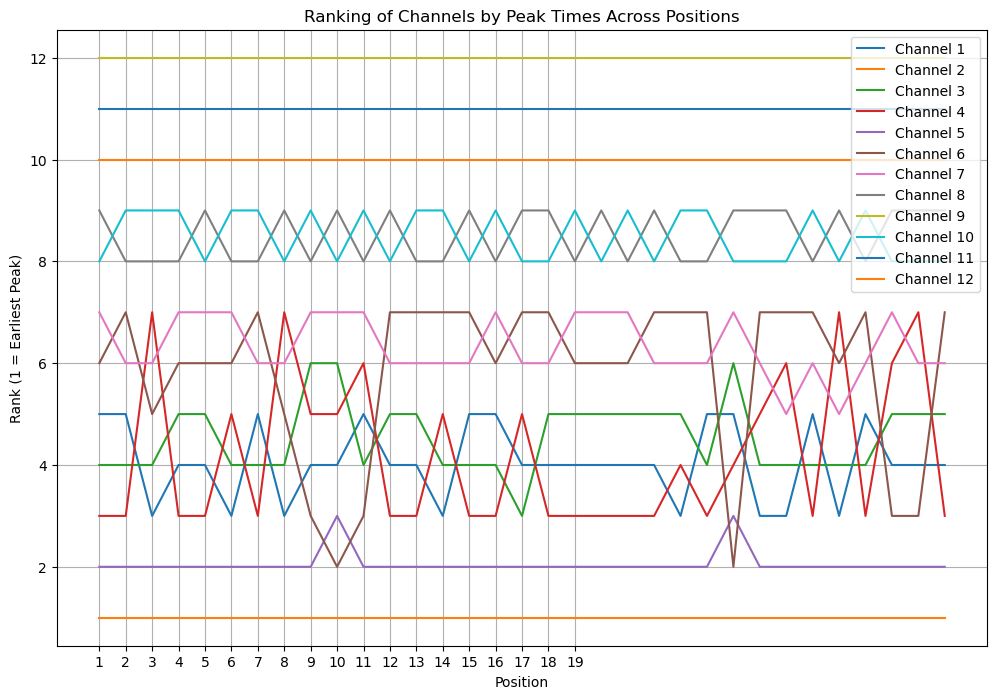

In [28]:
ranks = peak_rank_time(peaks)
relative_latency = peak_rank(peaks)

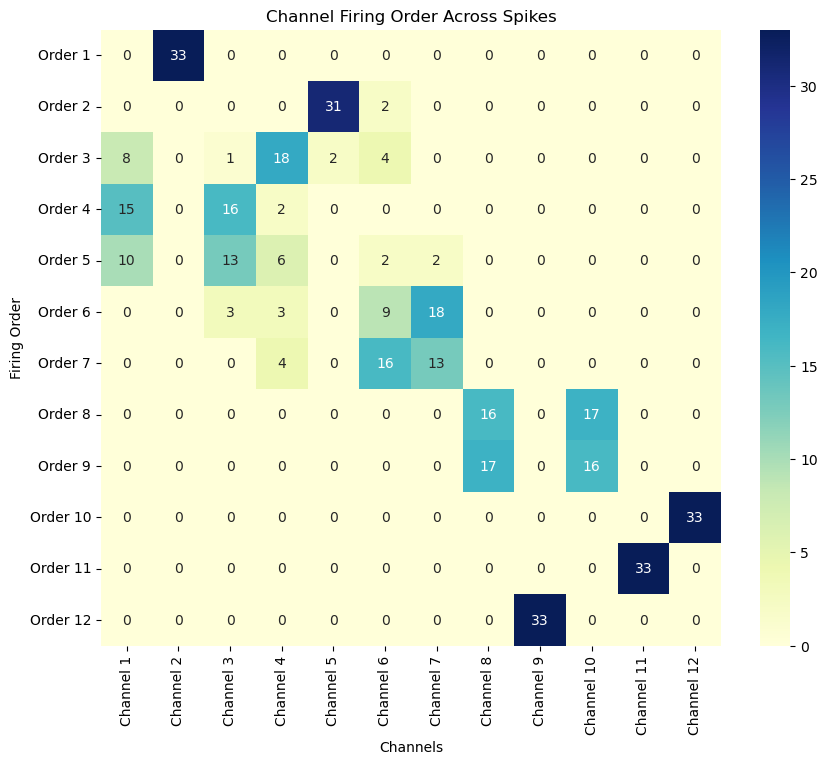

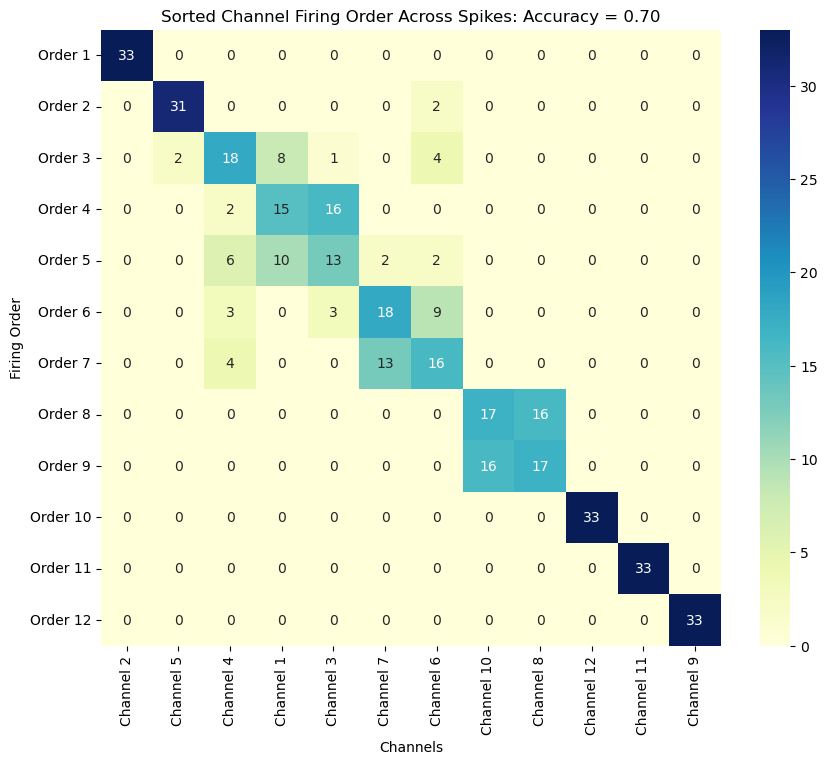

In [29]:
confusion_mat,col_ind = rank_confusion_matrix(peaks)
if cutoff_frequency == 1000:
    col_ind_1000 = col_ind.copy()
if use_raw_data:
    col_ind = col_ind_1000

25.190909090909088 1.283310972578976
0.0 0.0
25.790909090909093 1.9210735061360777
26.527272727272727 5.612554797047621
12.215151515151515 1.2844338953751622
31.996969696969693 9.923174127095496
35.39090909090908 0.8955660598153059
49.81818181818182 1.0737796584127195
61.92424242424242 0.8883182282064349
49.7030303030303 0.9133636961834911
61.31515151515152 0.8880080576078648
55.736363636363635 0.9058122696059017
(12, 33)


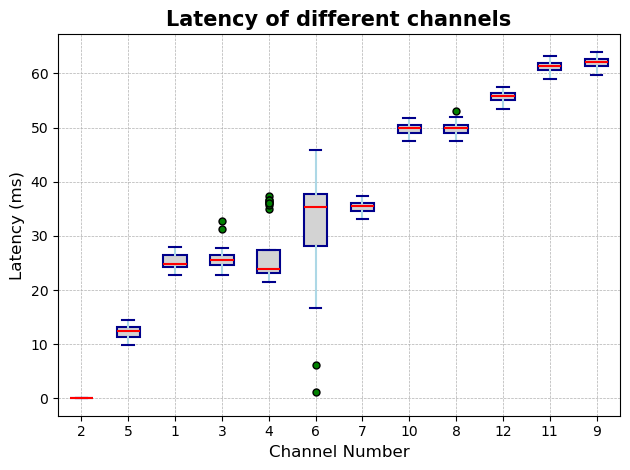

In [30]:
latency_all_ms = latency_all/10
for i in range(latency_all_ms.shape[0]):
    print(np.mean(latency_all_ms[i]), np.std(latency_all_ms[i]))
print(latency_all_ms.shape) #(16,53)
# Calculating the means of each row
means = np.mean(latency_all_ms, axis=1)

# Sorting the means and corresponding rows
sorted_indices = np.argsort(means)
sorted_data = latency_all_ms[sorted_indices]

# Generating channel numbers based on sorted indices (+1 for human-readable format)
channel_numbers = [f"{i+1}" for i in sorted_indices]

# Plotting
fig, ax = plt.subplots()
boxprops = dict(linestyle='-', linewidth=1.5, color='darkblue')
whiskerprops = dict(linestyle='-', linewidth=1.5, color='lightblue')
capprops = dict(linestyle='-', linewidth=1.5, color='darkblue')
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
flierprops = dict(marker='o', markerfacecolor='green', markersize=5, linestyle='none')

box = ax.boxplot(sorted_data.T, labels=channel_numbers, vert=True, patch_artist=True,
                 boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
                 medianprops=medianprops, flierprops=flierprops)

for patch in box['boxes']:
    patch.set_facecolor('lightgrey')

ax.set_title('Latency of different channels', fontsize=15, fontweight='bold')
ax.set_xlabel('Channel Number', fontsize=12)
ax.set_ylabel('Latency (ms)', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [2]:

print("Define Fitting Functions")
import sys
import os
sys.path.append('E:\\Desktop\\omipolar\\DataPlotting')
import matplotlib.pyplot as plt
from organoidContour import spike
from organoidContour.spike import *
import organoidContour as oc
from organoidContour import preprocessing
import numpy as np
import pickle
from organoidContour import spike
from organoidContour.spike import *
from organoidContour import map
import importlib
importlib.reload(map)
from organoidContour.map import *
from organoidContour.triangular import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import seaborn as sns
import importlib
import sys
sys.path.append('E:\\Desktop\\omipolar\\DataPlotting')
from organoidContour.triangular import *
from organoidContour.map import *
#target_indeces = [0,1,2,3,5,6,7,8,9,10,11,12,13, 14, 15]

print("This code calculate 3D velocities. Remeber to add empty row in xlsx")
import pandas as pd

# Load the Excel file
df = pd.read_excel('latency.xlsx')

# Convert the DataFrame to a 2D array
latencies = df.values*10

print(latencies.shape)
import numpy as np
latency = np.mean(latencies, axis=1)*1000 #it should be in the unit of 0.1 ms so the result is in cm/s
print(latency.shape)

latitudes = np.array([0, 60, -60, 0, 0, 60, -60, 0, 0, -60, 60, 0, 0, -60, 60, 0])
longitudes = np.array([22.5, 0, 90, 67.5, 112.5, 90, 180, 157.5, -22.5, 0, -90, -67.5, -112.5, -90, 180, -157.5])
latitudes = latitudes[target_indeces]
longitudes = longitudes[target_indeces]

distance_matrix = calculate_distance_matrix(longitudes, latitudes)
latency = np.mean(largest_slop - np.min(largest_slop, axis=0), axis= 1)
vec =  create_vector_field_spherical_coords(latency, longitudes, latitudes,distance_matrix, samples=2000, r = 250, scale =400)

Define Fitting Functions
This code calculate 3D velocities. Remeber to add empty row in xlsx


FileNotFoundError: [Errno 2] No such file or directory: 'latency.xlsx'

In [4]:
def grid_fitting_rbf_sphere(latency, longitudes, latitudes, distance_matrix,
        size_x=605, size_y=300, save=0, file_address='contour_sphere.png', electrodes=1, plot=1,
        colorbar=0, target_long=None, target_lat=None, divide_time_by=1,
        dense=1, color='black', epsilon=300.0, method='gaussian',levels=np.linspace(0, 50, 100)):

    latency = latency/divide_time_by
    A = Frbf(distance_matrix, epsilon=epsilon)
    lambda_ = np.linalg.solve(A, latency)

    if target_long is None:
        longitudes_grid = np.linspace(-180, 180, size_x)
        latitudes_grid = np.linspace(-90, 90, size_y)
        grid_x, grid_y = np.meshgrid(longitudes_grid, latitudes_grid)
        grid_x = grid_x.T
        grid_y = grid_y.T
        grid_z = np.zeros_like(grid_x)

        for i in range(grid_z.shape[0]):
            for j in range(grid_z.shape[1]):
                new_point_distances = calculate_distance_vector(
                    longitudes, latitudes, grid_x[i,j], grid_y[i,j])
                grid_z[i,j] = interpolate(new_point_distances, lambda_, epsilon=epsilon)/10
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        contour = ax.contourf(grid_x, grid_y, grid_z, levels=levels, cmap='jet')
        if electrodes:
            plt.scatter(longitudes, latitudes, c=color, edgecolor='k') 

        if save:
            ax.axis('off')
            plt.tight_layout(pad=0)
            fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
            fig.savefig(file_address, bbox_inches='tight', pad_inches=0, dpi=600)
            plt.close(fig)
        elif plot:
            plt.axis('equal')
            plt.xlim([-180,180])
            plt.ylim([-90,90])
            if colorbar:
                colorbar = plt.colorbar(contour)
                colorbar.set_label('Latency (ms)')
            plt.show()
        if not plot:
            plt.close()

    else:
        grid_z = []
        for longitude, latitude in zip(target_long, target_lat):
            new_point_distances = calculate_distance_vector(
                    longitudes, latitudes, longitude, latitude)
            grid_z.append(interpolate(new_point_distances, lambda_, epsilon=epsilon, method=method))
        grid_z_array = np.array(grid_z)

        return grid_z_array

    interpolated_at_original = np.dot(A, lambda_)
    difference = np.abs(interpolated_at_original - latency)
    #print("Differences:", difference)
    
    grid_variables = {
        "grid_x_full": grid_x,
        "grid_y_full": grid_y,
        "grid_z_full": grid_z,
        "grid_x_target": grid_x,
        "grid_y_target": grid_y,
        "grid_z_target": grid_z
    }
        
    return grid_variables



def setup_scene_and_capture(points, us, vs, scale=0.04,rotate_x = 0, rotate_y = 0, rotate_z = 200, radius=0.8, max_cv=None, min_cv=None, texture_file="contour.png"):
    """Sets up the renderer, renders the window with arrows, rotates, captures screenshots, and saves them to a folder."""
    # Create renderer and render window
    renderer = vtk.vtkRenderer()
    render_window = vtk.vtkRenderWindow()
    render_window.SetSize(1200, 1200)  # Larger window size
    render_window.AddRenderer(renderer)
    renderer.SetBackgroundAlpha(0)  
    renderer.SetBackground(1, 1, 1)  # Set the background to white
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)
    render_window.SetAlphaBitPlanes(1)  # Enable alpha channel
    render_window.SetMultiSamples(0)   # Disable multi-sampling for better transparency


    # Setup camera
    camera = renderer.GetActiveCamera()
    camera.ParallelProjectionOn()
    camera.SetPosition(0, 0, 10)  # Observe from bottom
    camera.SetFocalPoint(0, 0, 0)  # Look at the center of the sphere
    camera.SetViewUp(0, 1, 0)     # Set the upward direction
    renderer.AutomaticLightCreationOff()
    renderer.UseShadowsOff()
    renderer.SetAmbient(1.0, 1.0, 1.0)
    # Render objects
    create_sphere(renderer, radius=radius, resolution=100, rotate_x=rotate_x, rotate_y=rotate_y, rotate_z=rotate_z, texture_file=texture_file)
    for idx, (lon, lat) in enumerate(points):
        position = lat_lon_to_cartesian(lat, lon, radius)
        north = north_vector(lat, lon, radius)
        east = east_vector(position, north)
        direction = us[idx] * east + vs[idx] * north
        amplitude = np.sqrt(np.sum(us[idx]**2 + vs[idx]**2))
        normalized_intensity = (amplitude - min_cv) / (max_cv - min_cv) if max_cv and min_cv else (amplitude - 10) / (90)
        normalized_intensity = np.clip(normalized_intensity, 0, 1)
        color = jet_colormap(normalized_intensity)
        direction = direction / np.linalg.norm(direction)
        add_arrow(renderer, position, direction, scale * np.log(np.log(amplitude) + 5), color)

    # Create directory if it doesn't exist
    directory = "sphere_vector"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Initialize Window to Image Filter
    w2if = vtk.vtkWindowToImageFilter()
    w2if.SetInput(render_window)
    w2if.SetScale(1)  # Image quality
    w2if.SetInputBufferTypeToRGBA()
    w2if.ReadFrontBufferOff()
    
    # Initialize the writer
    writer = vtk.vtkPNGWriter()

    # Rotate and capture images
    for i in range(36):  # 360 degrees in steps of 10 degrees
        camera.Azimuth(10)  # Rotate camera
        render_window.Render()  # Render the scene
        w2if.Modified()  # Update the filter to reflect new scene
        w2if.Update()  # Ensure the filter processes the latest image
        writer.SetInputConnection(w2if.GetOutputPort())
        writer.SetFileName(f"{directory}/screenshot_{i}.png")
        writer.Write()

    render_window_interactor.Start()




In [44]:
grid_sphere = grid_fitting_rbf_sphere(latency,longitudes, latitudes,distance_matrix,
                                      electrodes= 0,
                        plot = 1, save = 1,levels=np.linspace(-6, 80, 10000), file_address='contour.png')

In [40]:
print(grid_sphere['grid_z_full'].max() )
print(grid_sphere['grid_z_full'].min() )

76.42231878400108
-5.908962672030521


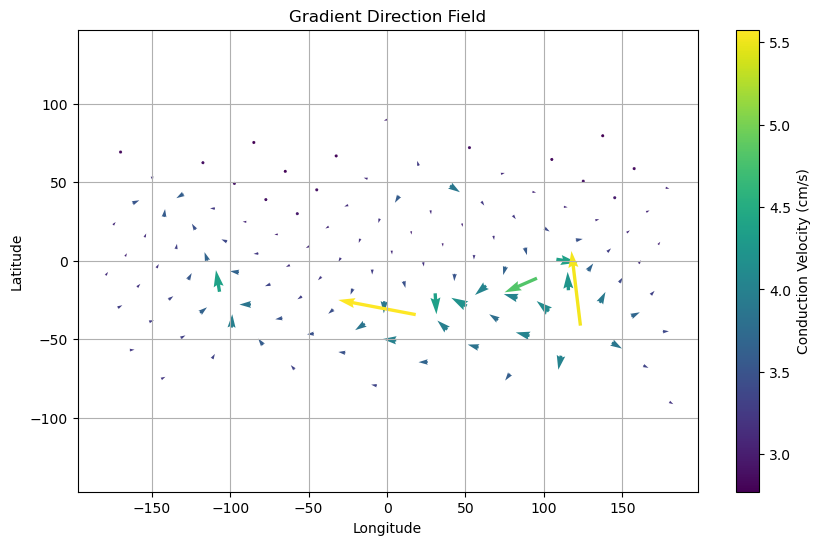

2.599431036002553 1.7001212746174663 3.2482602736952026 0.5998783069617847 25.415991393367584


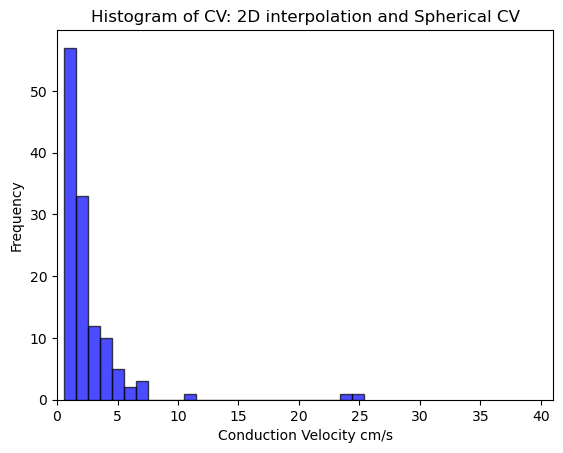

In [41]:
# Spherical CV
from organoidContour import map
import importlib
importlib.reload(map)
from organoidContour.map import *
vectors_sphere = create_vector_field_spherical_coords_grids(grid_sphere['grid_x_target'],
                    grid_sphere['grid_y_target'],
                    grid_sphere['grid_z_target'],
                    samples=125, r = 500, deltaD = None)

amp_sph = np.sqrt(np.array(vectors_sphere['us'])**2+np.array(vectors_sphere['vs'])**2)/10
print(np.mean(amp_sph), np.median(amp_sph), np.std(amp_sph),np.min(amp_sph), np.max(amp_sph))
plt.hist(amp_sph.flatten(),bins=25, alpha=0.7, color='blue', edgecolor='black')
plt.xlim([0,41])
plt.title('Histogram of CV: 2D interpolation and Spherical CV')
plt.xlabel('Conduction Velocity cm/s')
plt.ylabel('Frequency')
plt.show()

In [36]:
sss

NameError: name 'sss' is not defined

In [9]:
setup_scene_and_capture([],[],[],
                  scale = 0.04, rotate_x= 0, rotate_y= 0, rotate_z = 200
                  , radius= 0.8, min_cv=1, max_cv=10,texture_file="contour.png")

In [6]:
setup_scene_and_capture([],[],[],
                  scale = 0.04, rotate_x= 0, rotate_y= 0, rotate_z = 200
                  , radius= 0.8, min_cv=1, max_cv=10,texture_file="contour_arhythmia_epsilon_200_electrode.png")
